# SARIMA with calls

In [1]:
# # https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

# https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

In [2]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [2]:
from datetime import datetime, date 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings

warnings.simplefilter(action='ignore')

In [3]:
import platform
print(platform.python_version())

3.8.5


In [4]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [3]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [1]:
# grid search arima parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.calls, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

NameError: name 'pdq' is not defined

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 18858.03. Therefore we should consider this to be optimal option.

In [10]:
# fitting the arima model

mod = sm.tsa.statespace.SARIMAX(df.calls.iloc[:920],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
#print(results.summary())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1662      0.037      4.470      0.000       0.093       0.239
ma.L1         -0.9198      0.015    -59.721      0.000      -0.950      -0.890
ar.S.L12      -0.0968      0.034     -2.812      0.005      -0.164      -0.029
ma.S.L12      -0.9779      0.019    -51.399      0.000      -1.015      -0.941
sigma2       1.03e+06   5.49e+04     18.766      0.000    9.22e+05    1.14e+06


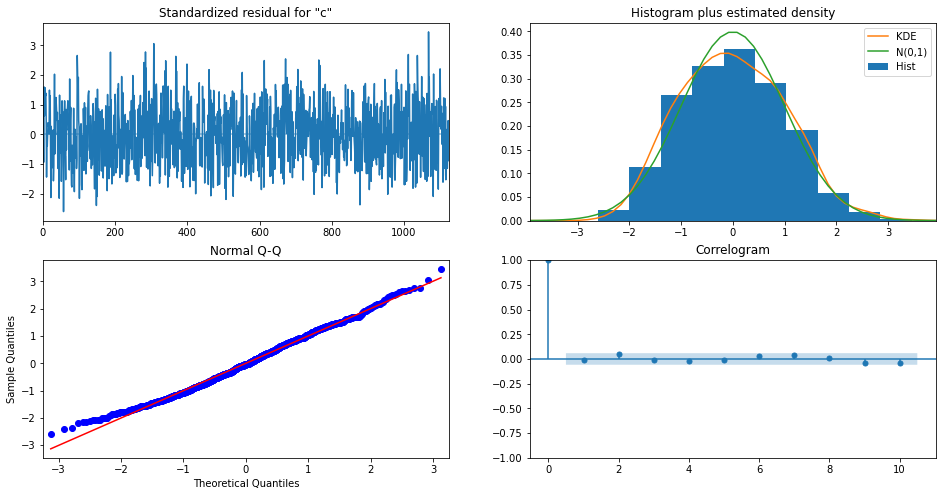

In [6]:
# run model diagnostics to investigate any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.
<br>
<br>
Is KDE curve similar??
<br>
<br>
Most of the points should lie on the straight line
<br>
<br>

In [7]:
df = df[['date', 'calls']]
# df = df.set_index('date')
df.index

RangeIndex(start=0, stop=1152, step=1)

<AxesSubplot:>

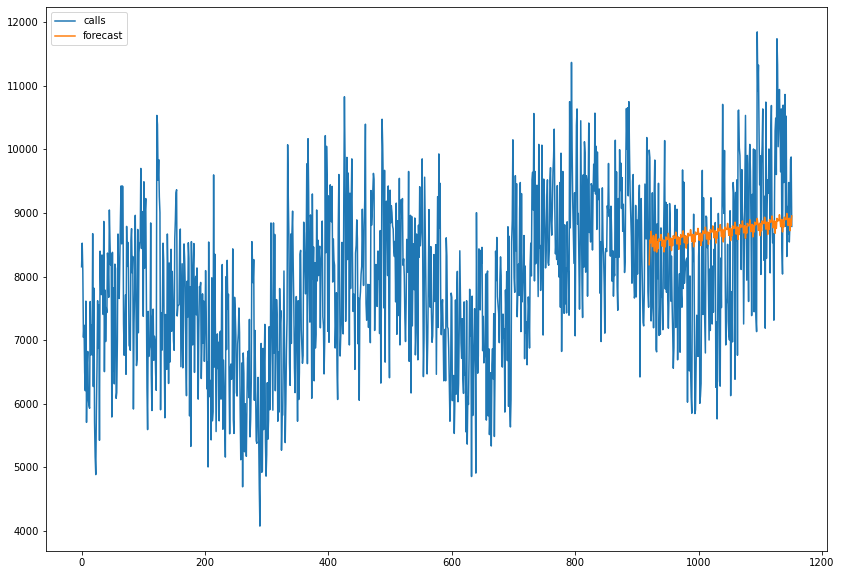

In [13]:
# Validating forecasts

df['forecast']=results.predict(start=920, end=1151, dynamic=True)
df[['calls','forecast']].plot(figsize=(14,10))

In [15]:
df_noindex = df.drop(columns=['date', 'forecast'])
df_noindex

,calls
0,8154.0
1,8526.0
2,8088.0
3,7044.0
4,7236.0
...,...
1147,8544.0
1148,8814.0
1149,9846.0
1150,9882.0


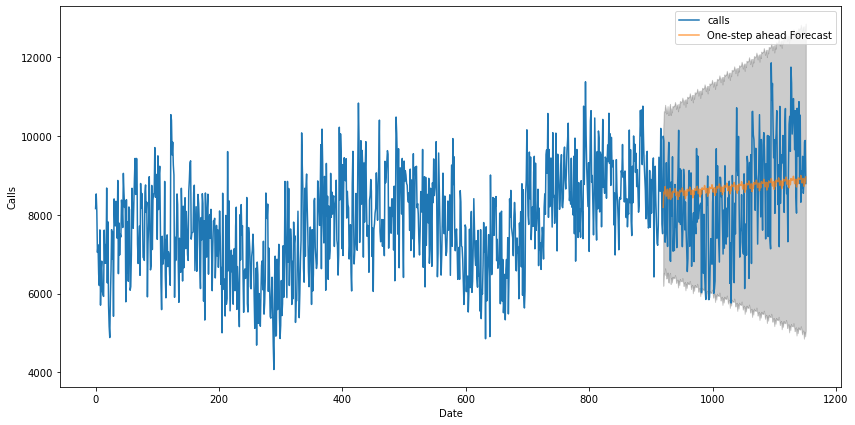

In [20]:

pred = results.get_prediction(start=920, end=1151, dynamic=False)
pred_ci = pred.conf_int()
ax = df_noindex.iloc[0:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Calls')
#ax.set_xticks((0, 920))
#ax.set_xticklabels(['1. 4. 2016', '8. 10. 2018'])
#plt.axvline(x=920, color = 'red')
plt.legend()
plt.show()

In [21]:
# with pred mean
y_forecasted = pred.predicted_mean
y_truth = df.calls[920:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1632449.55
The Root Mean Squared Error is 1277.67


In [26]:
series1=results.predict(start=920, end=1151, dynamic=False)

series2 = pred.predicted_mean

In [27]:
y_forecasted2 = series1
y_truth2 = df.calls[920:]
mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse2, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse2), 2)))

The Mean Squared Error of our forecasts is 1632449.55
The Root Mean Squared Error is 1277.67


In [30]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_truth2, y_forecasted2)

1632449.54845636

In [ ]:
series1

920     8214.721084
921     8530.766946
922     8525.769947
923     8650.421269
924     8613.597515
           ...     
1147    8936.582751
1148    8752.903901
1149    8882.278100
1150    8821.686546
1151    8930.937731
Name: predicted_mean, Length: 232, dtype: float64

In [ ]:
series2

920     8214.721084
921     8959.771777
922     8952.797347
923     8671.698789
924     8411.206297
           ...     
1147    9728.951077
1148    9361.304941
1149    9366.157076
1150    9421.022485
1151    9702.401681
Name: predicted_mean, Length: 232, dtype: float64